<a href="https://colab.research.google.com/github/dewaalaw/dsprojects/blob/main/search-term-analysis/src/coffee_search_trend_part_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Development Environment

In [ ]:
import datetime

import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import Model, Sequential

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError

from tensorflow.keras.layers import Dense, Conv1D, LSTM, Lambda, Reshape, RNN, LSTMCell

import warnings
warnings.filterwarnings('ignore')

## Read Training Data

In [ ]:
csv_path = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00492/Metro_Interstate_Traffic_Volume.csv.gz'

In [ ]:
csv_columns = ['holiday', 'temp', 'rain_1h', 'snow_1h', 'clouds_all', 
               'weather_main', 'weather_description', 'date_time', 'traffic_volume']
df = pd.read_csv(csv_path, names=csv_columns, header=0)
df.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,None,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545
1,None,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516
2,None,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767
3,None,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026
4,None,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918


In [ ]:
df.shape

(48204, 9)

# Data Exploration

In [ ]:
df['date_time'] = pd.to_datetime(df['date_time'])
df = df.drop_duplicates(subset='date_time', ignore_index=True)
df.shape

(40575, 9)

In [ ]:
date_range = list(pd.date_range('2012-10-02 09:00:00', '2018-09-30 23:00:00', freq='H')) #space-out date range hourly
print(len(date_range))

52551


In [ ]:
temp_df = pd.DataFrame({'date_time':date_range})
df = pd.merge(temp_df, df, how='left', on='date_time')
#df.head()

In [ ]:
df.isna().sum()

date_time                  0
holiday                11976
temp                   11976
rain_1h                11976
snow_1h                11976
clouds_all             11976
weather_main           11976
weather_description    11976
traffic_volume         11976
dtype: int64

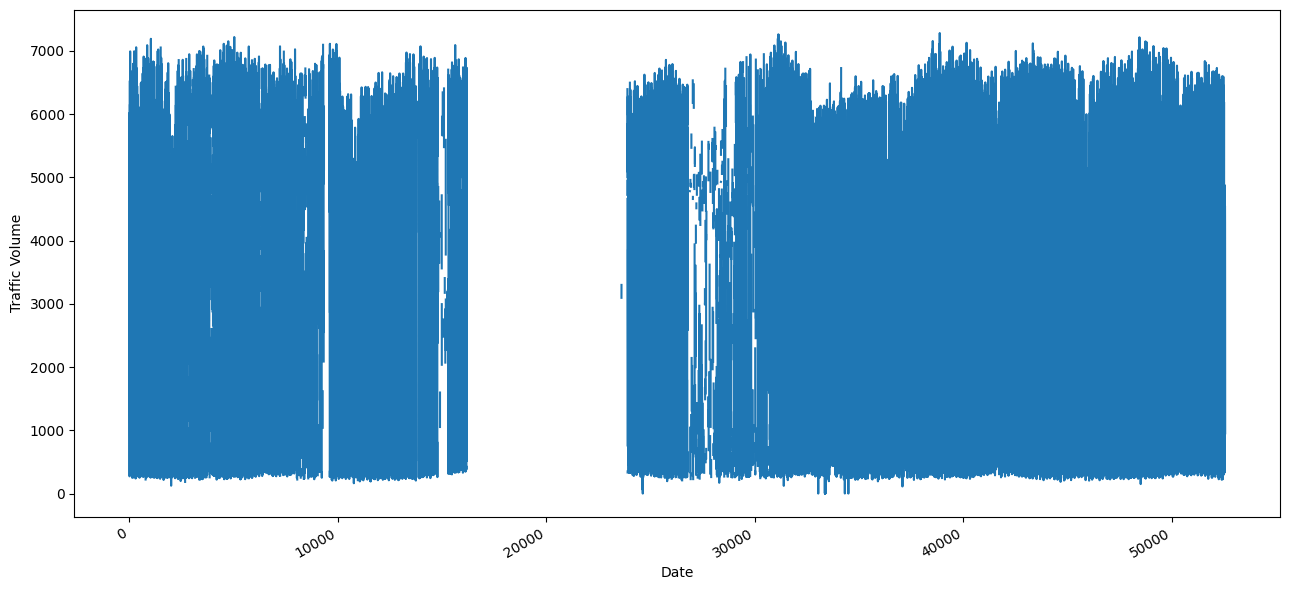

In [ ]:
fig, ax = plt.subplots(figsize=(13, 6))
ax.plot(df.traffic_volume)
ax.set_xlabel('Date')
ax.set_ylabel('Traffic Volume')

fig.autofmt_xdate()
plt.tight_layout()

In [ ]:
df = df[35000:].reset_index(drop=True) #Collect from 35000th row, resetting index
# df.head(5)

In [ ]:
df = df.drop(['holiday', 'weather_main', 'weather_description'], axis=1)
# df.shape

In [ ]:
df = df.fillna(df.groupby(df.date_time.dt.hour).transform('median'))

In [ ]:
df.isna().sum()

date_time         0
temp              0
rain_1h           0
snow_1h           0
clouds_all        0
traffic_volume    0
dtype: int64

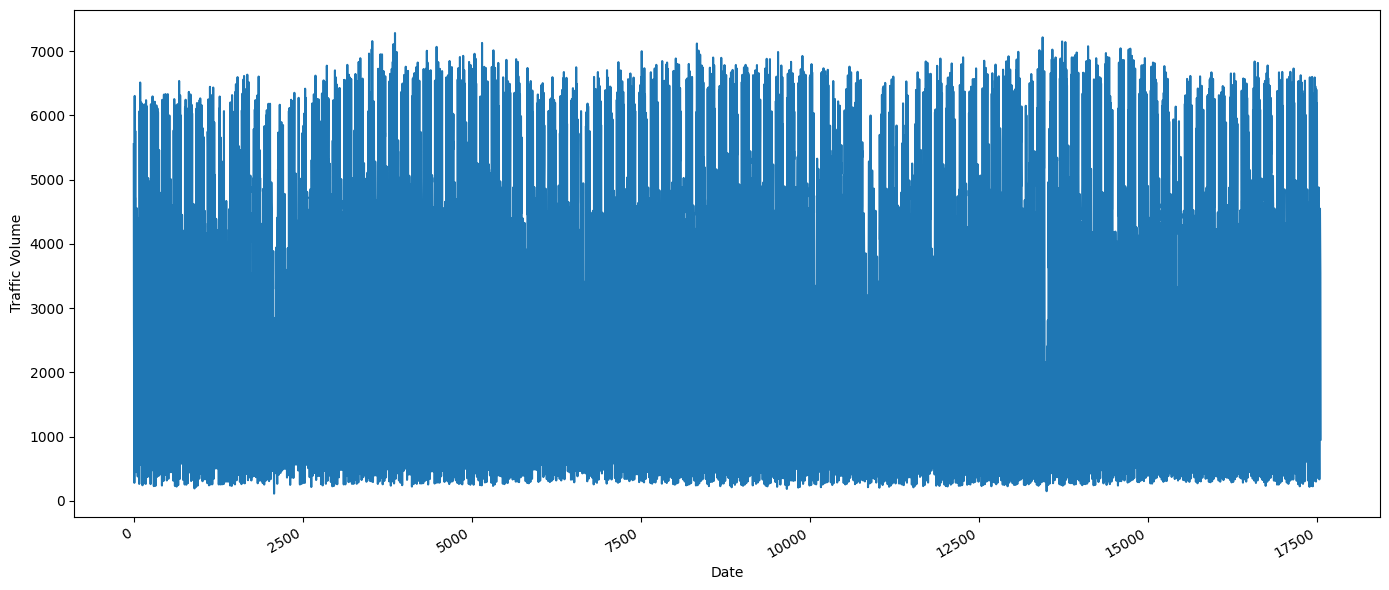

In [ ]:
fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(df.traffic_volume)
ax.set_xlabel('Date')
ax.set_ylabel('Traffic Volume')

fig.autofmt_xdate()
plt.tight_layout()

In [ ]:
from google.colab import drive
drive.mount('/gdrive')
df.to_csv('/gdrive/MyDrive/TrafficFlowData/metro_interstate_traffic_volume_preprocessed.csv')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


## Visualise Traffic Evolution Over Time

Wesbound traffic volume on I-94 between Minneapolis and St Paul in Minnesota, starting on September 29, 2016, at 5 p.m. Daily seasonility is clearly vissible, traffic being lower at the start and end of each day.

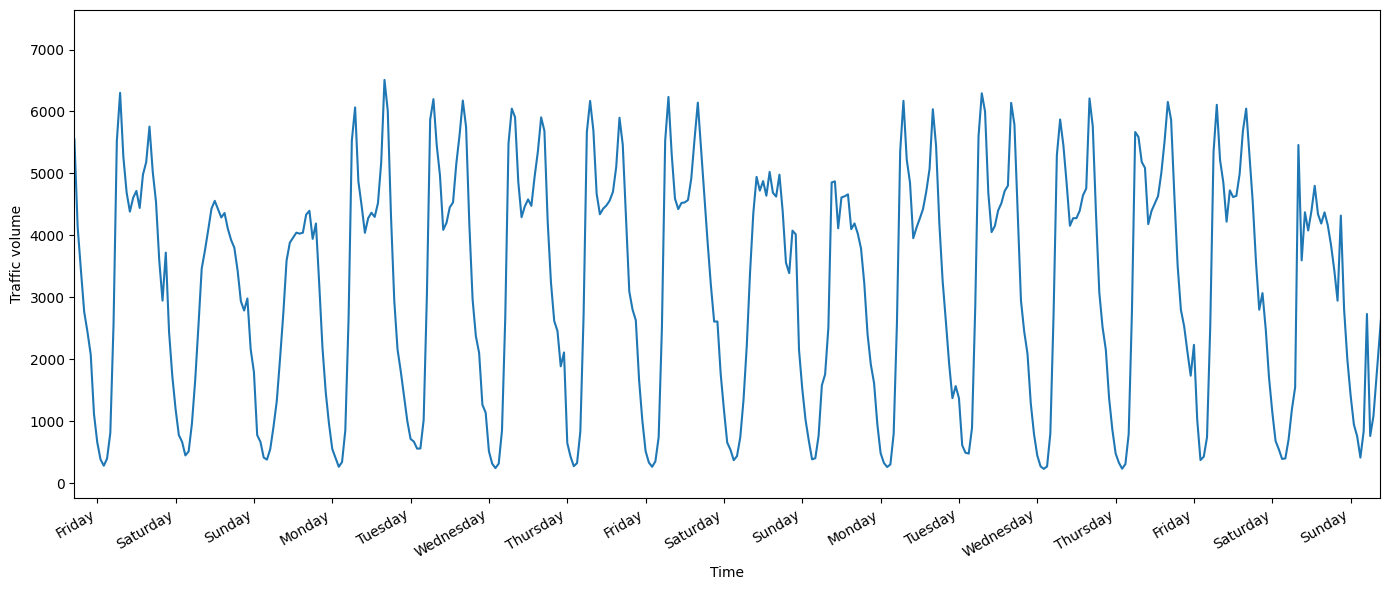

In [ ]:
fig, ax = plt.subplots(figsize=(14,6))
ax.plot(df['traffic_volume'])
ax.set_xlabel('Time')
ax.set_ylabel('Traffic volume')

plt.xticks(np.arange(7, 400, 24), ['Friday', 'Saturday', 'Sunday', 'Monday', 
                                   'Tuesday', 'Wednesday', 'Thursday', 
                                   'Friday', 'Saturday', 'Sunday', 'Monday', 
                                   'Tuesday', 'Wednesday', 'Thursday', 
                                   'Friday', 'Saturday', 'Sunday' ])
plt.xlim(0, 400)
fig.autofmt_xdate()
plt.tight_layout()

## Visualise Hourly Temperature Over Time

Hourly temperature (in Kelvin) from September 29, 2016, to September 30, 2018. Yearly seasonality is rather apparent despite the slight noise.

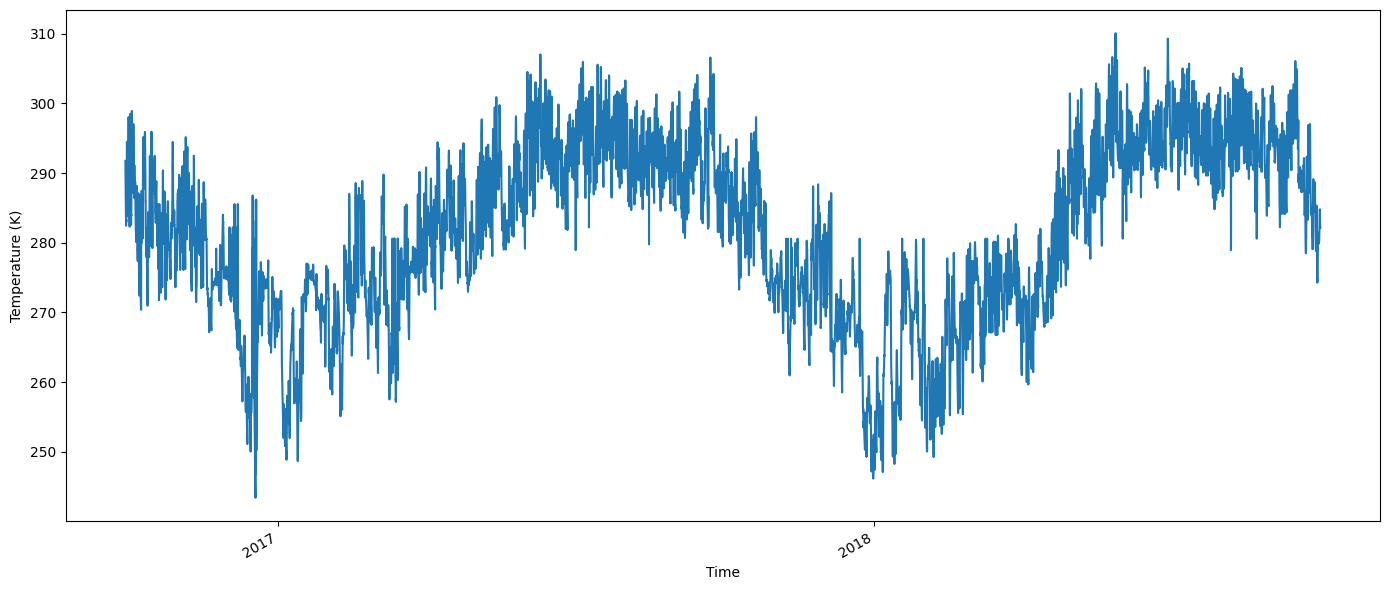

In [ ]:
fig, ax = plt.subplots(figsize = (14, 6))
ax.plot(df['temp'])
ax.set_xlabel('Time')
ax.set_ylabel('Temperature (K)')

plt.xticks([2239, 10999], [2017, 2018])

fig.autofmt_xdate()
plt.tight_layout()

## Verify Whether Daily Seasonality's Observable

Hourly Temperature in Kelvin starting on September 29, 2016 at 5pm. CST. Despite the noise we can see that temperatures are indeed lower at the start of each day, the end of each day, and peak during midday, suggesting daily seasonality.

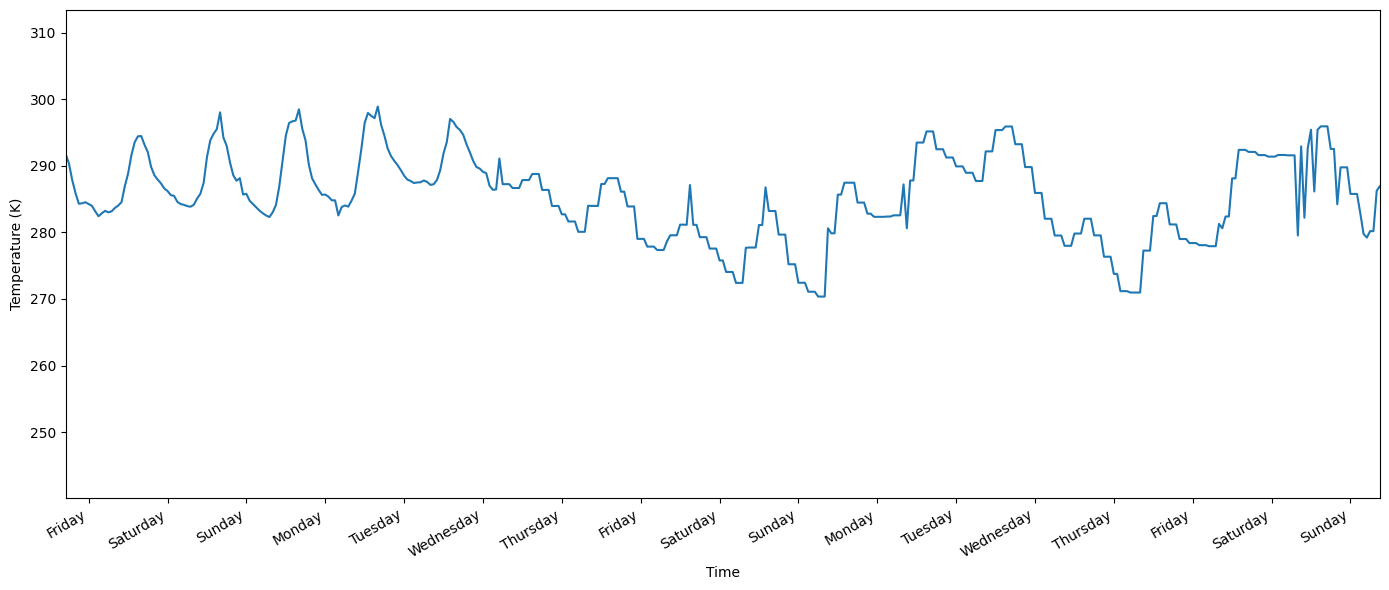

In [ ]:
fig, ax = plt.subplots(figsize=(14,6))
ax.plot(df['temp'])
ax.set_xlabel('Time')
ax.set_ylabel('Temperature (K)')

plt.xticks(np.arange(7, 400, 24), ['Friday', 'Saturday', 'Sunday', 'Monday', 
                                   'Tuesday', 'Wednesday', 'Thursday', 
                                   'Friday', 'Saturday', 'Sunday', 'Monday', 
                                   'Tuesday', 'Wednesday', 'Thursday', 
                                   'Friday', 'Saturday', 'Sunday' ])
plt.xlim(0, 400)
fig.autofmt_xdate()
plt.tight_layout()

# Feature Engineering and Data Splitting

In [ ]:
df.describe()

,temp,rain_1h,snow_1h,clouds_all,traffic_volume
count,17551.000000,17551.000000,17551.0,17551.000000,17551.000000
mean,281.416203,0.025523,0.0,42.034129,3321.484588
std,12.688262,0.259794,0.0,39.065960,1969.223949
min,243.390000,0.000000,0.0,0.000000,113.000000
25%,272.220000,0.000000,0.0,1.000000,1298.000000
50%,282.410000,0.000000,0.0,40.000000,3518.000000
75%,291.890000,0.000000,0.0,90.000000,4943.000000
max,310.070000,10.600000,0.0,100.000000,7280.000000


In [ ]:
# Drop columns which are mostly naught throughout data (see Peixeiro 2022, pg 242)
cols_to_drop = ['rain_1h', 'snow_1h']
df = df.drop(cols_to_drop, axis=1)

In [ ]:
# Convert date_time from string to a numerical value of seconds (see Peixeiro 2022, pg 242)
# Retain cyclical nature of time by way of the sin transformation
timestamp_s = pd.to_datetime(df['date_time']).map(datetime.datetime.timestamp)
day = 24 * 60 * 60 # Number of seconds in a day
df['day_sin'] = (np.sin(timestamp_s * (2*np.pi/day))).values # Radians are used in the sine function

While the sin transformation regains the syclical property of time, it leaves indistinguished the difference between am and pm. We correct this by applying a cosine transformation—it being out of phase with the sine function—allowing thus the distinction between am and pm time. 

In [ ]:
df['day_cos'] = (np.cos(timestamp_s * (2*np.pi/day))).values
df = df.drop(['date_time'], axis=1)

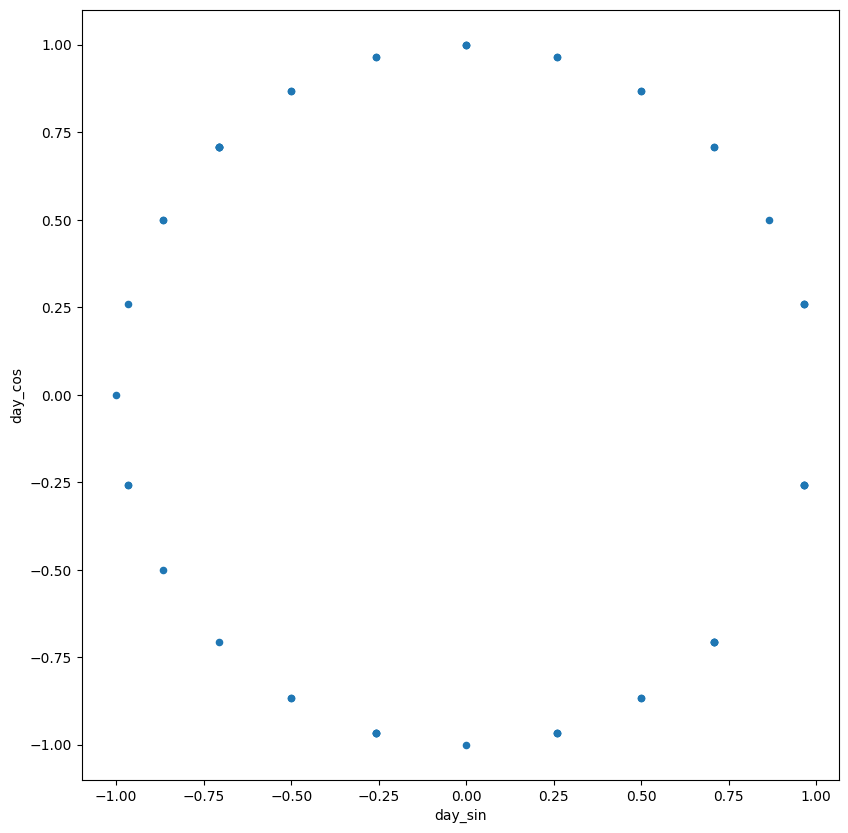

In [ ]:
# Confirm sine vs cosine function
df.sample(50).plot.scatter('day_sin', 'day_cos', figsize=(14, 10)).set_aspect('equal')

The above plot confims that we have converted the time strings to numerical values that retain the cyclical nature of time, a format conducive for deep learning models. 

## Split Data

In [ ]:
n = len(df)

# Split the data by train, validation, and test ration of 70:20:10
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

## Scale Data

As seen below, apart from normalising the data, scaling the data only affects the scale not its distribution, thus in this instance placing the values between 0 and 1. Normalising the data on the other hand affects the distribution and scale. 

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(train_df) # Abate date leakage by fitting the scaler on the train set

train_df[train_df.columns] = scaler.transform(train_df[train_df.columns])
val_df[val_df.columns] = scaler.transform(val_df[val_df.columns])
test_df[test_df.columns] = scaler.transform(test_df[test_df.columns])

## Save Data

In [ ]:
# Save each frame as a csv
train_df.to_csv('/gdrive/MyDrive/TrafficFlowData/metro_interstate_traffic_volume_train.csv')
val_df.to_csv('/gdrive/MyDrive/TrafficFlowData/metro_interstate_traffic_volume_validate.csv')
test_df.to_csv('/gdrive/MyDrive/TrafficFlowData/metro_interstate_traffic_volume_test.csv')